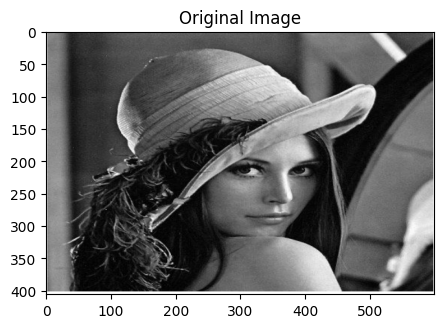

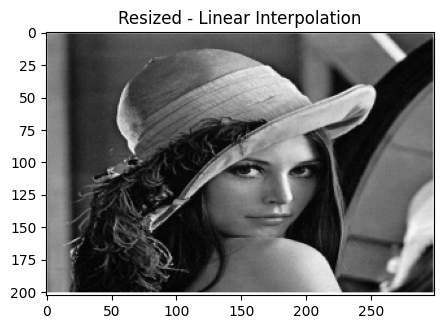

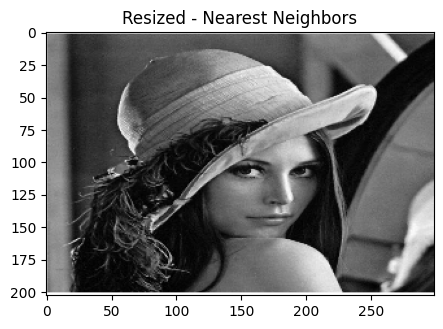

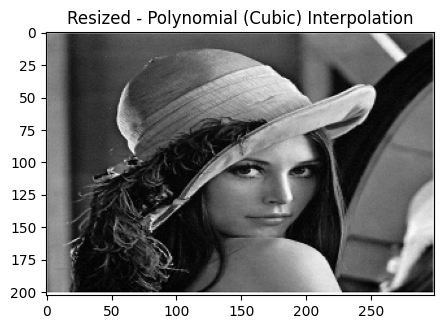

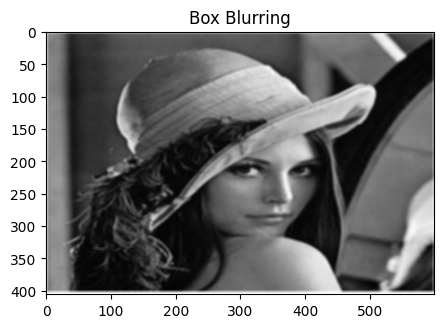

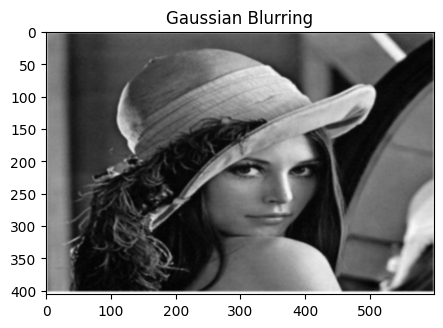

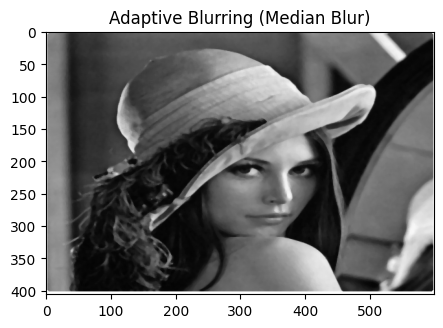

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to display images
def display(title, img):
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('on')
    plt.show()

# Load an image
image_path = '/content/Screenshot 2025-01-30 230754.png'  # Replace with the path to your image
image = cv2.imread(image_path)

if image is None:
    print("Error: Unable to load image.")
else:
    display("Original Image", image)

    # 1.1 Image Resizing
    height, width = image.shape[:2]

    # 1.1.1 Linear Interpolation
    resized_linear = cv2.resize(image, (width // 2, height // 2), interpolation=cv2.INTER_LINEAR)
    display("Resized - Linear Interpolation", resized_linear)

    # 1.1.2 Nearest Neighbors
    resized_nearest = cv2.resize(image, (width // 2, height // 2), interpolation=cv2.INTER_NEAREST)
    display("Resized - Nearest Neighbors", resized_nearest)

    # 1.1.3 Polynomial (Cubic interpolation)
    resized_cubic = cv2.resize(image, (width // 2, height // 2), interpolation=cv2.INTER_CUBIC)
    display("Resized - Polynomial (Cubic) Interpolation", resized_cubic)

    # 1.2 Image Blurring
    # 1.2.1 Box Blurring (Averaging filter)
    box_blur = cv2.blur(image, (5, 5))
    display("Box Blurring", box_blur)

    # 1.2.2 Gaussian Blurring
    gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)
    display("Gaussian Blurring", gaussian_blur)

    # 1.2.3 Adaptive Blurring (Median Blur)
    adaptive_blur = cv2.medianBlur(image, 5)
    display("Adaptive Blurring (Median Blur)", adaptive_blur)

Path to dataset files: /root/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1
Files in dataset directory: ['t10k-images-idx3-ubyte', 'train-labels.idx1-ubyte', 'train-labels-idx1-ubyte', 't10k-labels.idx1-ubyte', 'train-images-idx3-ubyte', 't10k-labels-idx1-ubyte', 't10k-images.idx3-ubyte', 'train-images.idx3-ubyte']
--- Naive Bayes Results ---
Accuracy: 0.5563
Precision: 0.6933
Recall: 0.5563
F1-Score: 0.5186
Confusion Matrix:
[[ 873    0    3    5    2    5   31    0   31   30]
 [   0 1082    2    1    0    0   10    0   35    5]
 [  77   25  291   80    5    1  262    4  267   20]
 [  34   39    6  357    1    3   54    8  395  113]
 [  22    2    6    4  167    9   66    7  196  503]
 [  77   24    2   21    2   48   40    2  574  102]
 [  12   12    5    1    1    6  894    0   26    1]
 [   0   15    2    9    6    1    5  267   42  681]
 [  14   74    3    8    4   13   14    3  627  214]
 [   4    7    3    6    0    0    1   12   19  957]]


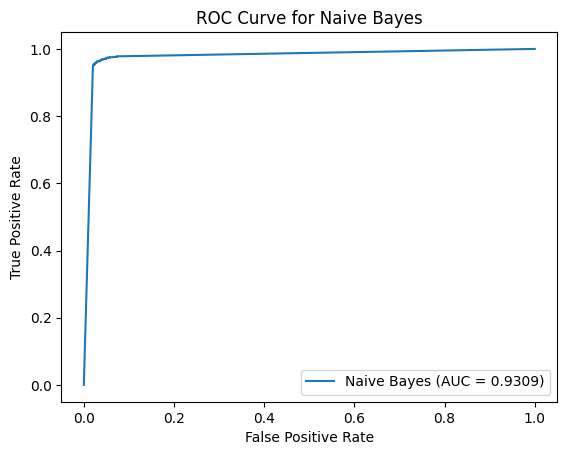

--- Random Forest Results ---
Accuracy: 0.9687
Precision: 0.9687
Recall: 0.9687
F1-Score: 0.9687
Confusion Matrix:
[[ 971    0    1    0    0    2    2    1    3    0]
 [   0 1123    3    2    0    2    2    1    2    0]
 [   6    0  998    3    4    0    4    8    9    0]
 [   0    0   13  971    0    5    0    9   10    2]
 [   1    0    3    0  956    0    4    0    2   16]
 [   4    0    1   11    3  857    7    1    4    4]
 [   8    3    0    0    2    4  938    0    3    0]
 [   1    3   19    4    1    0    0  985    4   11]
 [   3    0    2   13    5    4    2    4  931   10]
 [   5    6    4   10   13    3    2    5    4  957]]


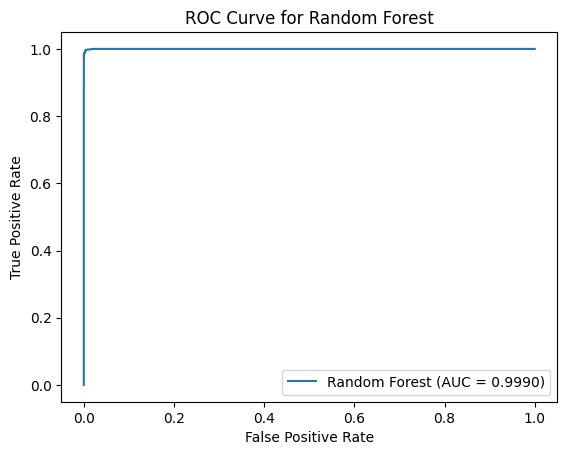

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
from struct import unpack
import os
import kagglehub

# Step 1: Download the dataset using kagglehub
dataset_name = "hojjatk/mnist-dataset"
path = kagglehub.dataset_download(dataset_name)
print("Path to dataset files:", path)

# Step 2: List all files in the dataset directory to verify file paths
print("Files in dataset directory:", os.listdir(path))

# Correct file paths - Add the filenames
train_images_path = os.path.join(path, "train-images-idx3-ubyte", "train-images-idx3-ubyte")  # Changed
train_labels_path = os.path.join(path, "train-labels-idx1-ubyte", "train-labels-idx1-ubyte")  # Changed
test_images_path = os.path.join(path, "t10k-images-idx3-ubyte", "t10k-images-idx3-ubyte")  # Changed
test_labels_path = os.path.join(path, "t10k-labels-idx1-ubyte", "t10k-labels-idx1-ubyte")  # Changed



# Step 3: Define functions to parse IDX files
def load_idx(file_path):
    with open(file_path, 'rb') as f:
        magic, size = unpack('>II', f.read(8))
        if magic == 2051:  # Image file
            rows, cols = unpack('>II', f.read(8))
            data = np.fromfile(f, dtype=np.uint8).reshape(size, rows * cols)
        elif magic == 2049:  # Label file
            data = np.fromfile(f, dtype=np.uint8)
        else:
            raise ValueError(f"Unknown magic number {magic} in file {file_path}")
    return data

# Load training and testing data
X_train_full = load_idx(train_images_path) / 255.0  # Normalize pixel values
y_train_full = load_idx(train_labels_path)
X_test = load_idx(test_images_path) / 255.0  # Normalize pixel values
y_test = load_idx(test_labels_path)

# Step 4: Split training data into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Step 5: Define models
models = {
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Step 6: Evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation predictions
    y_pred_cv = cross_val_predict(model, X_train, y_train, cv=skf, method="predict")
    y_prob_cv = cross_val_predict(model, X_train, y_train, cv=skf, method="predict_proba") if hasattr(model, "predict_proba") else None

    # Final predictions on test set
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_prob_test = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    # Metrics
    accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, average="weighted")
    recall = recall_score(y_test, y_pred_test, average="weighted")
    f1 = f1_score(y_test, y_pred_test, average="weighted")
    cm = confusion_matrix(y_test, y_pred_test)

    # ROC and AUC (only for models with probabilistic output)
    if y_prob_test is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob_test[:, 1], pos_label=1)
        roc_auc = roc_auc_score(y_test, y_prob_test, multi_class='ovr')
    else:
        fpr, tpr, roc_auc = None, None, None

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm,
        "roc_curve": (fpr, tpr) if fpr is not None else None,
        "roc_auc": roc_auc
    }

# Step 7: Evaluate models and display results
for model_name, model in models.items():
    results = evaluate_model(model, X_train, y_train, X_test, y_test)

    print(f"--- {model_name} Results ---")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"F1-Score: {results['f1']:.4f}")
    print(f"Confusion Matrix:\n{results['confusion_matrix']}")

    if results["roc_curve"]:
        fpr, tpr = results["roc_curve"]
        plt.figure()
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {results['roc_auc']:.4f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for {model_name}")
        plt.legend(loc="best")
        plt.show()


TASK-2